In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
from pathlib import Path
from PIL import Image
import numpy as np

In [ ]:
#custom pythorch dataset for video-based modal to amodal mask prediction

class VideoModalToAmodalDataset(Dataset):
    def __init__(self, sample_dir, num_frames=24):
        self.sample_dir = Path(sample_dir)
        # organize images into a nested dictionary structure by camera and object
        self.sample_dict = self.get_sample_dict(self.sample_dir)
        # sorted list of all camera folders
        self.cameras = sorted([p.name for p in self.sample_dir.glob("camera_*")])
        # a list of object IDs from the first camera folder (all camera folders have the same obj)
        self.obj_ids = [x for x in self.sample_dict[self.cameras[0]] if 'obj_' in x]
        self.num_frames = num_frames  # how many frames to load per video sequence

    def __len__(self):  # total number of samples:  number of cameras × number of objects. Each sample=entire video
        return len(self.obj_ids) * len(self.cameras)

    def __getitem__(self, idx):  # convert flat index into camera and obj indices
        cam_idx = idx // len(self.obj_ids) # which camera this index corrosponds to, eg: if there are 3 objects and idx=4, then cam_idx is 1 (seconodn camera)
        obj_idx = idx % len(self.obj_ids) # which object to load for this index, same concept as above.

        cam_name = self.cameras[cam_idx]
        obj_id = self.obj_ids[obj_idx]

        rgb_seq = [] # will hold 24 input frames (each frame is RGB + modal mask, so 4 channels)
         # get paths for the current frame: RGB image, modal segmentation, and amodal segmentation
        for frame_idx in range(self.num_frames): # loop over all frames in the video
            rgb_path = self.sample_dict[cam_name]['scene']['rgba'][frame_idx]
            modal_path = self.sample_dict[cam_name]['scene'['segmentation'][frame_idx]
            amodal_path = self.sample_dict[cam_name][obj_id]['segmentation'][frame_idx]

            rgb = ToTensor()(Image.open(rgb_path).convert('RGB')) # convert img to tensor ( 3,256,256)
            modal_np = np.array(Image.open(modal_path))  # load modal segmentation mask as np.array
            # get the obj index as integer ( 'obj_0002' -> 2)
            obj_int = int(obj_id.split('_')[1])
            # make binary mask for object_int, if pixel matches obj ID then is 1.
            modal_mask = torch.tensor((modal_np == obj_int).astype(np.float32)).unsqueeze(0)
            # combine RGB and modal mask into a single 4-channel tensor
            input_frame = torch.cat((rgb, modal_mask), dim=0)  # (4, 256, 256)
            rgb_seq.append(input_frame)

        video_tensor = torch.stack(rgb_seq)  # stack list into a tensor (24, 4, 256, 256)
        video_tensor = video_tensor.permute(1, 0, 2, 3)  # rearrange dim to : (4 channels, 24 frames, 256, 256)
         # load the last amodal mask and normalize all pixel values to [0, 1] bc nerual network expect inputs and outputs to be in range [0,1]
        amodal_mask_np = np.array(Image.open(amodal_path).convert('L')) / 255.0 # 'L' is grayscale
         # convert to tensor and add channel dimension: (1, 256, 256)
        amodal_mask = torch.tensor(amodal_mask_np, dtype=torch.float32).unsqueeze(0)

        return video_tensor, amodal_mask # return video seq as input and amodal mask as target

    def get_sample_dict(self, sample_dir):
        def get_img_dict(img_dir):
            img_files = list(img_dir.glob("*.png")) + list(img_dir.glob("*.tiff"))
            img_files.sort()
            img_dict = {}
            for f in img_files:
                key = f.name.split('_')[0]
                img_dict.setdefault(key, []).append(f)
            return img_dict

        sample_dict = {}  #build  nested dictionary: camera → scene & object segmentations
        for cam_dir in sorted(sample_dir.glob("camera_*")):
            cam_dict = {'scene': get_img_dict(cam_dir)}  # add scence level files
            for obj_dir in sorted(cam_dir.glob("obj_*")):
                cam_dict[obj_dir.name] = get_img_dict(obj_dir) # add obj segmentations
            sample_dict[cam_dir.name] = cam_dict
        return sample_dict


In [ ]:
# instead of using the default collate we use custom collate to batch multiple input-target pairs together,
# this way we ensure correct batch shape
def custom_collate(batch):
    # unpack the batch into two tuples: one with all inputs, one with all targets
    # batch = [(input1, target1), (input2, target2), ...]
    inputs, targets = zip(*batch)
    inputs = torch.stack(inputs) # stack all input tensors into a single batch tensor of shape (B, C, D, H, W), c=channel, D= depth or time (nube of frames in video)
    targets = torch.stack(targets) # stack all target amodal masks into a single tensor of shape (B, 1, H, W). B=batch size( number of samples in a batch)
    return inputs, targets

In [ ]:
# define a 3D unet architecture
# each blocks follows this patters: Conv3D → BatchNorm3D → ReLU → Conv3D → BatchNorm3D → ReLU
class DoubleConv3D(nn.Module):# double: two conv layers in a row- to learn more complexity.
    def __init__(self, in_ch, out_ch):  # in_ch = number of input channels, out_ch = number of output channels
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, kernel_size=3, padding=1), # first 3d convolution layer
            nn.BatchNorm3d(out_ch), # Since we are working with video or 3D volumes .normalize output
            nn.ReLU(inplace=True),# apply non-linear activation function
            nn.Conv3d(out_ch, out_ch, kernel_size=3, padding=1),# second 3d conolution layer
            nn.BatchNorm3d(out_ch), # normalize output again.
            nn.ReLU(inplace=True) # ReLU (Rectified Linear Unit) activation function, itvadds nonlinearity to the mode.
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
# use DoubleConv3D inside UNet3D
# 3D Unet adapted for video-based segmentation
class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=1): # 3 RGB + 1 modal mask as input.Output: a 1-channel amodal mask.
        super().__init__()
        # Encoder: downsample path or contract
        self.enc1 = DoubleConv3D(in_channels, 32) # first encoding block- learns low-level feature: like edges, corners..
        self.pool1 = nn.MaxPool3d(2) # reduces spatial and temporal size by half (stride 2).
        self.enc2 = DoubleConv3D(32, 64) # second encoding block- learns more abstract features
        self.pool2 = nn.MaxPool3d(2) # downsampling again to reduce complexity.

        self.bottleneck = DoubleConv3D(64, 128) # deepst laters or central processign layer.Learns the global structure after downsampling.
        # decoder: upsamples (doubles) resolution to reverse pooling
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = DoubleConv3D(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.dec1 = DoubleConv3D(64, 32)

        self.out_conv = nn.Conv3d(32, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        b = self.bottleneck(p2)

        u2 = self.up2(b)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        out = self.out_conv(d1)  # final ouput layer
        return out.mean(dim=2)  # dim=2 bc we need a 2d amodal mask


In [ ]:
sample_dir = "ff5da6d6ecae486bb294aeaf5ee8f8a1"
dataset = VideoModalToAmodalDataset(sample_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# Note for Team: currnly batch size is 1 for debuggin purposees during intitia development but
# once model stables and memory allows we can increase this
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate) #batch size =1 for debugging purpose
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=custom_collate)


In [ ]:
# for the purpose of debugging- not required for trainign
from pathlib import Path

sample_dir = Path("ff5da6d6ecae486bb294aeaf5ee8f8a1")
print("Folders in sample_dir:")
for item in sample_dir.iterdir():
    print(" -", item.name)



Folders in sample_dir:
 - camera_0003
 - camera_0000
 - camera_0001
 - camera_0005
 - camera_0002
 - camera_0004


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D(in_channels=4, out_channels=1).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import torch.nn as nn

# BCEWithLogitsLoss (handles sigmoid internally)- this was also used in Amar's code.
loss_fn = nn.BCEWithLogitsLoss()

model.train()
for epoch in range(1):  # YOU CAN INCREAE THIS LATER
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        print("Input shape (batched):", inputs.shape)  # Expect [B, 4, 24, 256, 256]

        preds = model(inputs)             # Raw logits
        loss = loss_fn(preds, targets)    # No sigmoid here

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # To the team:  Can be removed or disabled once training is stable and memory is not an issue.
        torch.cuda.empty_cache()


Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256, 256])
Input shape (batched): torch.Size([1, 4, 24, 256

In [ ]:
model.eval()
total_loss = 0.0

with torch.no_grad(): # disable gradient tracking for faster evaluation and lower memory usage
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        preds = model(inputs)              # raw logits
        loss = loss_fn(preds, targets)     # BCEWithLogitsLoss expects raw logits
        total_loss += loss.item()

avg_test_loss = total_loss / len(test_loader)
print(f"Average Test Loss: {avg_test_loss:.4f}")

# Note to team:
# The test loss may appear high initially due to:
#  1- Low number of training epochs (currently just 1)
#  2- Small batch size (currently set to 1 for debugging)
#  3- Possible model underfitting or data imbalance
# We expect test loss to improve with:
#  1- More training epochs
# 2 - Larger batch sizes (e.g., 4 or 8, depending on memory limits)


Average Test Loss: 0.7049


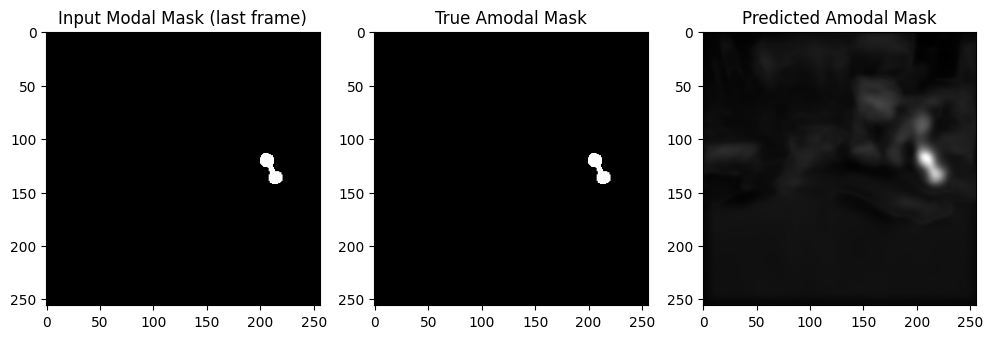

In [ ]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad(): # get one batch of test data (batch size = 1 for debugging puprpose)
    inputs, targets = next(iter(test_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    preds = model(inputs)  # get model predictions (logits) on the test input

idx = 0
input_modal = inputs[idx, 3, -1].cpu().numpy()  # last frame, modal mask
true_amodal = targets[idx, 0].cpu().numpy()
# or should it be:?
# pred_amodal = torch.sigmoid(preds[idx, 0]).cpu().numpy()

pred_amodal = preds[idx, 0].cpu().numpy()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input Modal Mask (last frame)")
plt.imshow(input_modal, cmap='gray')
plt.subplot(1, 3, 2)
plt.title("True Amodal Mask")
plt.imshow(true_amodal, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Predicted Amodal Mask")
plt.imshow(pred_amodal, cmap='gray')
plt.show()
